# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.classifier import ROCAUC


sys.path.insert(0, r"d:\ML\Fake News Detection")
from src.data_audit import DataAudit


In [2]:
PATH_TO_DATA = r"d:\ML\Fake News Detection\data\liar_processed.csv"
data = pd.read_csv(PATH_TO_DATA)
print(data.shape)

(12791, 18)


In [3]:
train = pd.read_csv(r"d:\ML\Fake News Detection\data\train.csv")
test = pd.read_csv(r"d:\ML\Fake News Detection\data\test.csv")
valid = pd.read_csv(r"d:\ML\Fake News Detection\data\valid.csv")

In [4]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_valid = valid.drop(columns=['label'])
y_valid = valid['label']
X_test = test.drop(columns=['label'])
y_test = test['label']
X_combined = pd.concat([X_train, X_valid], axis=0)
y_combined = pd.concat([y_train, y_valid], axis=0)
split_indices = np.concatenate([
    -1 * np.ones(X_train.shape[0]), 
     0 * np.ones(X_valid.shape[0]) 
])

split = PredefinedSplit(test_fold=split_indices)

We will firstly conduct some experiments using Linear kernel

In [5]:
def linear_grid_search(X, y, pipeline):
    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__class_weight': ['balanced']
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=split,
                               scoring='f1_weighted',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_

In [6]:
def rbf_grid_search(X, y, pipeline):
    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10],
        'classifier__gamma': [0.001, 0.01, 0.1, 1],
        'classifier__class_weight': ['balanced']
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=5,
                               scoring='f1_weighted',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_

In [7]:
predictions = len(data) * [3]
accuracy = accuracy_score(data['label'], predictions)
precision = precision_score(data['label'],
                            predictions,
                            average='weighted',
                            zero_division=0)
recall = recall_score(data['label'],
                      predictions,
                      average='weighted',
                      zero_division=0)
f1 = f1_score(data['label'], predictions, average='weighted', zero_division=0)
report = []
report.append({
    "model": "Baseline(predicting the most common class)",
    "C": None,
    "gamma": None,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

In [8]:
def calculate_metrics(y_true, y_pred, model_name, model):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    clf = model.named_steps["classifier"]
    report.append({
        "model": model_name,
        "C": getattr(clf, "C", None),
        "gamma": getattr(clf, "gamma", None),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    print(f"F1 Score: {f1:.3f}")

In [9]:
def save_to_excel(report, filename='decision_tree_report.xlsx'):
    df_report = pd.DataFrame(report)
    df_report.to_excel(filename, index=False)

The biggest benefit of svm might be the results we get on the text column, so let us see what we can get from there

In [10]:

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(random_state=42))
])
model = linear_grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "LinearSVC", model)

F1 Score: 0.232


Let us try with rbf kernel, but trying with less examples, so that it doesnt take too long time

In [16]:

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42))
])
indices = X_combined.index
np.random.seed(42)
indices = np.random.choice(indices, size=1000, replace=False)
X_rbf = X_combined.loc[indices]
y_rbf = y_combined.loc[indices]
print(X_rbf.shape, y_rbf.shape)
model = rbf_grid_search(X_rbf, y_rbf, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Rbf", model)

(1213, 17) (1213,)
F1 Score: 0.207


Let us try giving it a little more observations

In [17]:

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42))
])
indices = X_combined.index
np.random.seed(42)
indices = np.random.choice(indices, size=2000, replace=False)
X_rbf = X_combined.loc[indices]
y_rbf = y_combined.loc[indices]
print(X_rbf.shape, y_rbf.shape)
model = rbf_grid_search(X_rbf, y_rbf, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Rbf", model)

(2439, 17) (2439,)
F1 Score: 0.247


We see a much better result now. Maybe we should use the params we got from the last model

In [18]:
print(report)

[{'model': 'Baseline(predicting the most common class)', 'C': None, 'gamma': None, 'accuracy': 0.20537878195606285, 'precision': 0.04218044407775601, 'recall': 0.20537878195606285, 'f1': 0.06998703595778663}, {'model': 'LinearSVC', 'C': 10, 'gamma': None, 'accuracy': 0.23204419889502761, 'precision': 0.23272001696052882, 'recall': 0.23204419889502761, 'f1': 0.2317788156786177}, {'model': 'Rbf', 'C': 10, 'gamma': 1, 'accuracy': 0.22336227308603, 'precision': 0.22204506074519545, 'recall': 0.22336227308603, 'f1': 0.20740060999664306}, {'model': 'Rbf', 'C': 1, 'gamma': 1, 'accuracy': 0.2549329123914759, 'precision': 0.2596834176051197, 'recall': 0.2549329123914759, 'f1': 0.24688324089923464}]


Let us train that model on the whole dataset.

In [19]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.258


An excellent 0.258 score, it looks like it is better to use rbf instead of Linear SVC,

We should also try different techniques like removing stopwords

In [20]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.261


Now, we will compare it with Count vectorizer

In [21]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(stop_words='english'), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.090


With Count vectorizer we got an extremely low result, we should stick with tf-idf. Let us try with all features

In [22]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.157


We got a worse score, maybe we shoul try reducing number of column. We will use the three most influential , judging by our random forest importances

In [23]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)
numerical_cols = ['truth_index', 'statement_length', 'total_history']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
        ('num', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.171


It looks like the svm doesnt really use the metadatas, let us try different vectorization techniques then

In [24]:
def stemmed_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [25]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(tokenizer=stemmed_tokenizer, stop_words='english'), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.255


Not a good result, let us try bi_grams

In [26]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.255


Not an improvement, let us limit the words of our best model until now

In [28]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=1000), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.244


Well, it looks like out best model will remain using statement column with combination of Tfidf vectorizer removing stopwords

In [10]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.261


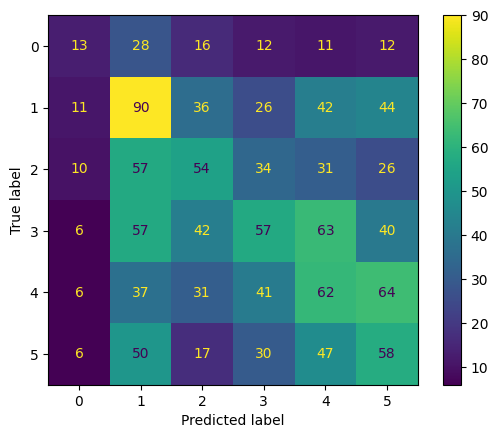

In [30]:
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

AttributeError: 'float' object has no attribute 'show'

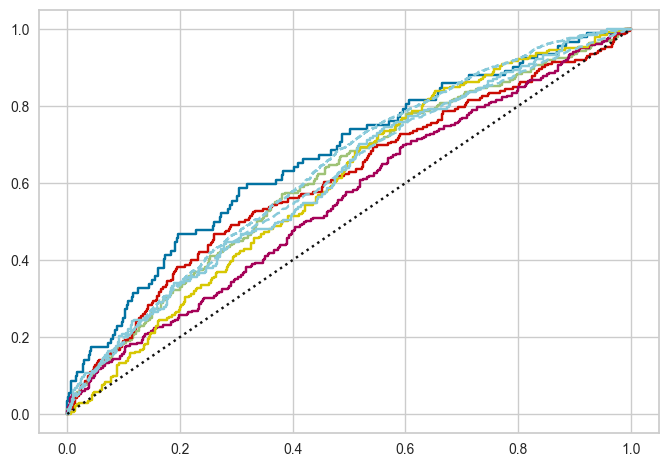

In [11]:
visualizer = ROCAUC(pipeline, classes=[0,1,2,3,4,5]).fit(X_train, y_train).score(X_test, y_test).show()

In [31]:
save_to_excel(report, filename='svm_report.xlsx')

One last experiment with scaling:

In [34]:
svm = SVC(kernel='rbf', C=1, gamma=1, class_weight='balanced', random_state=42)
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', numeric_transformer, numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm),
])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "Rbf", pipeline)

F1 Score: 0.181


In [35]:
print(report)

[{'model': 'Baseline(predicting the most common class)', 'C': None, 'gamma': None, 'accuracy': 0.20537878195606285, 'precision': 0.04218044407775601, 'recall': 0.20537878195606285, 'f1': 0.06998703595778663}, {'model': 'LinearSVC', 'C': 10, 'gamma': None, 'accuracy': 0.23204419889502761, 'precision': 0.23272001696052882, 'recall': 0.23204419889502761, 'f1': 0.2317788156786177}, {'model': 'Rbf', 'C': 10, 'gamma': 1, 'accuracy': 0.22336227308603, 'precision': 0.22204506074519545, 'recall': 0.22336227308603, 'f1': 0.20740060999664306}, {'model': 'Rbf', 'C': 1, 'gamma': 1, 'accuracy': 0.2549329123914759, 'precision': 0.2596834176051197, 'recall': 0.2549329123914759, 'f1': 0.24688324089923464}, {'model': 'Rbf', 'C': 1, 'gamma': 1, 'accuracy': 0.2596685082872928, 'precision': 0.26053506568283413, 'recall': 0.2596685082872928, 'f1': 0.25777565325985885}, {'model': 'Rbf', 'C': 1, 'gamma': 1, 'accuracy': 0.26361483820047354, 'precision': 0.26439917712327177, 'recall': 0.26361483820047354, 'f1':